# Framework

## Instructions

To run this notebook, you need to upload the **`Data`** folder provided in the **`source code.zip`** file to your google drive or Colab Notebook runtime.

This folder contains the following files needed in this notebook:

1. trained weights of the models that can be loaded directly to make inference
2. sample data for you to test the performance of the model

You also need to change the directories at a few places within the notebook to successfully load the data. These are all indicated using comments.

In [53]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
import os
import csv
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from transformers import AutoModel, AutoTokenizer
from transformers import Wav2Vec2Model, Wav2Vec2Processor

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

## Set Device

In [3]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


## Load Pre-trained Models

In [ ]:
roberta = AutoModel.from_pretrained('roberta-large')
tokenizer = AutoTokenizer.from_pretrained('roberta-large')
wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

## Load Data

In [57]:
def load_data(text_path, audio_path, label_path):
    """
    Input:
        text_path   | should be a .txt file, each row is a single utterance
        audio_path  | should be a folder path, contains .wav files 
        label_path  | should be a .txt file, labels seperated by commas
    """
    labels = []
    with open(label_path, 'r') as f:
        for row in csv.reader(f, delimiter=','):
            for item in row:
                if item.isdigit():
                    labels.append(int(item))
    text_data = []
    with open(text_path, 'r') as f:
        for row in csv.reader(f, delimiter='\n'):
            for item in row:
                text_data.append(item)
    audio_data = []
    for file_name in tqdm(os.listdir(audio_path)):
        if file_name == '.DS_Store':
            continue
        file_path = os.path.join(audio_path, file_name)
        y = librosa.load(file_path, sr=16000)[0]
        y_fixed = librosa.util.fix_length(y, size=160000)
        audio_data.append(y_fixed)
    return text_data, audio_data, labels

In [58]:
# change the directories to the Data folder
audio_path = "/content/drive/MyDrive/Colab Notebooks" + "/Data/Inference/sample audio"
text_path = "/content/drive/MyDrive/Colab Notebooks" + "/Data/Inference/sample text.txt"
label_path = "/content/drive/MyDrive/Colab Notebooks" + "/Data/Inference/sample labels.txt"

text_data, audio_data, labels = load_data(text_path, audio_path, label_path)

100%|██████████| 14/14 [00:00<00:00, 254.44it/s]


In [59]:
classes = np.array(['angry', 'excited', 'happy', 'sad', 'frustrated', 'neutral', 'surprise'])

## Feature Extractor

In [60]:
class FeatureExtractor:

    def __init__(self, params):
        self.device = params['device']
        self.batch_size = params['batch_size']
        self.text_model = params['text_model'].to(self.device)
        self.tokenizer = params['tokenizer']
        self.audio_model = params['audio_model'].to(self.device)
        self.processor = params['processor']
        self.text_data = params['text_data']
        self.audio_data = params['audio_data']
    
    def extract_text_features(self):
        encoded_text = self.tokenizer.batch_encode_plus(list(text_data),
                                                        padding=True,
                                                        truncation=True,
                                                        return_tensors='pt').to(self.device)
        print('Text data encoded.')
        text_dataset = TensorDataset(encoded_text['input_ids'], encoded_text['attention_mask'])
        text_loader = DataLoader(text_dataset, batch_size=self.batch_size)
        text_features = []
        first = True
        for input_ids, attention_mask in tqdm(text_loader):
            with torch.no_grad():
                outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
            if first:
                text_features = outputs
                first = False
            else:
                text_features = torch.concat((text_features,outputs), dim=0)
            del outputs
        print('Text features extracted.')
        return text_features
    
    def extract_audio_features(self):
        encoded_audio = processor(list(audio_data),
                                  sampling_rate=16000,
                                  padding=True,
                                  truncation=True,
                                  max_length=160000,
                                  return_tensors="pt").input_values.to(self.device)
        print('Audio data encoded.')
        audio_loader = DataLoader(TensorDataset(encoded_audio), batch_size=self.batch_size)
        first = True
        for data in tqdm(audio_loader):
            with torch.no_grad():
                outputs = self.audio_model(data[0]).last_hidden_state
            if first:
                audio_features = outputs
                first = False
            else:
                audio_features = torch.concat((audio_features,outputs), dim=0)
            del outputs
        print('Audio features extracted.')
        return audio_features

In [61]:
extractor_params = {'device': device,
                    'batch_size': 4,
                    'text_model': roberta,
                    'tokenizer': tokenizer,
                    'audio_model': wav2vec,
                    'processor': processor,
                    'text_data': text_data,
                    'audio_data': audio_data}
extractor = FeatureExtractor(extractor_params)

In [62]:
text_features = extractor.extract_text_features()

Text data encoded.


100%|██████████| 4/4 [00:16<00:00,  4.24s/it]

Text features extracted.


In [63]:
audio_features = extractor.extract_audio_features()

Audio data encoded.


100%|██████████| 4/4 [00:48<00:00, 12.10s/it]

Audio features extracted.


## Models: Self-MHA & Cross-MHA

In [64]:
class SSE_Self(nn.Module):
    """
    Bimodal (audio & text) self-attention model with self-supervised embeddings.
    """

    def __init__(self, params):
        super(SSE_Self, self).__init__()
        # multi-head self-attention
        self.mha_t = nn.MultiheadAttention(embed_dim=params['embed_size'],
                                           num_heads=params['txt_H'],
                                           dropout=params['txt_dropout'],
                                           batch_first=True)
        self.mha_a = nn.MultiheadAttention(embed_dim=params['embed_size'],
                                           num_heads=params['aud_H'],
                                           dropout=params['aud_dropout'],
                                           batch_first=True)
        # fully-connected layers
        self.dim_reduction = nn.Linear(in_features=params['txt_embed_size'],
                                       out_features=params['embed_size'])
        self.concat_linear = nn.Linear(in_features=int(2 * params['embed_size']),
                                       out_features=int(0.5 * params['embed_size']))
        self.classifier = nn.Linear(in_features=int(0.5 * params['embed_size']),
                                    out_features=params['output_dim'])

    def forward(self, x_txt, x_aud):
        """
        Input:
            x_txt   | text embeddings from RoBERTa, embedding size = 1024
            x_aud   | audio embeddings from Wav2Vec 2.0, embeddings size = 768
        Output:
            y       | unnormalized logits, shape = (batch_size, n_class)
            x_ta    | fused text-audio features, shape = (batch_size, 384)
        """
        # dimension reduction
        x_txt = self.dim_reduction(x_txt)
        # multi-head self-attention
        x_txt, _ = self.mha_t(x_txt, x_txt, x_txt)
        x_aud, _ = self.mha_a(x_aud, x_aud, x_aud)
        # temporal average as global representation
        x_txt_avg = torch.mean(x_txt, dim=1)
        x_aud_avg = torch.mean(x_aud, dim=1)
        # concatenating text and audio features
        x_ta = torch.stack((x_txt_avg, x_aud_avg), dim=1)
        # statistical pooling
        x_ta_std, x_ta_mean = torch.std_mean(x_ta, dim=1)
        x_ta = torch.cat((x_ta_mean, x_ta_std), dim=1)
        x_ta = self.concat_linear(x_ta)
        # classification
        y = self.classifier(x_ta)
        return y, x_ta


class SSE_Cross(nn.Module):
    """
    Bimodal (audio & text) cross-attention model with self-supervised embeddings.
    """
    def __init__(self, params):
        super(SSE_Cross, self).__init__()
        # multi-head cross-attention
        self.mha_ta = nn.MultiheadAttention(embed_dim=params['embed_size'],
                                            num_heads=params['ta_H'],
                                            dropout=params['ta_dropout'],
                                            batch_first=True)
        self.mha_at = nn.MultiheadAttention(embed_dim=params['embed_size'],
                                            num_heads=params['at_H'],
                                            dropout=params['at_dropout'],
                                            batch_first=True)
        # fully-connected layers
        self.dim_reduction = nn.Linear(in_features=params['txt_embed_size'],
                                       out_features=params['embed_size'])
        self.concat_linear = nn.Linear(in_features=int(2 * params['embed_size']),
                                       out_features=int(0.5 * params['embed_size']))
        self.classifier = nn.Linear(in_features=int(0.5 * params['embed_size']),
                                    out_features=params['output_dim'])

    def forward(self, x_txt, x_aud):
        """
        Input:
            x_txt   | text embeddings from RoBERTa, embedding size = 1024
            x_aud   | audio embeddings from Wav2Vec 2.0, embeddings size = 768
        Output:
            y       | unnormalized logits, shape = (batch_size, n_class)
            x_ta    | fused text-audio features, shape = (batch_size, 384)
        """
        # dimension reduction
        x_txt = self.dim_reduction(x_txt)
        # multi-head cross-attention
        x_t2a, _ = self.mha_ta(x_txt, x_aud, x_aud)
        x_a2t, _ = self.mha_at(x_aud, x_txt, x_txt)
        # temporal average as global representation
        x_t2a_avg = torch.mean(x_t2a, dim=1)
        x_a2t_avg = torch.mean(x_a2t, dim=1)
        # concatenating text and audio features
        x_ta = torch.stack((x_t2a_avg, x_a2t_avg), dim=1)
        # statistical pooling
        x_ta_std, x_ta_mean = torch.std_mean(x_ta, dim=1)
        x_ta = torch.cat((x_ta_mean, x_ta_std), dim=1)
        x_ta = self.concat_linear(x_ta)
        # classification
        y = self.classifier(x_ta)
        return y, x_ta

In [65]:
def load_model(model, path, deivce):
    weights = torch.load(path, map_location=device)
    model.load_state_dict(weights)
    return model

In [66]:
model_params = {'txt_embed_size': 1024,
                'embed_size': 768,
                'txt_H': 6,
                'aud_H': 6,
                'ta_H': 6,
                'at_H': 6,
                'txt_dropout': 0.1,
                'aud_dropout': 0.1,
                'ta_dropout': 0.1,
                'at_dropout': 0.1,
                'output_dim': 7}

In [77]:
# change the directory
sa_path = "/content/drive/MyDrive/Colab Notebooks" + '/Data/Inference/Models/model_sa.pt'
ca_path = "/content/drive/MyDrive/Colab Notebooks" + '/Data/Inference/Models/model_ca.pt'

model_sa = SSE_Self(model_params).to(device)
model_sa = load_model(model_sa, sa_path, device)

model_ca = SSE_Cross(model_params).to(device)
model_ca = load_model(model_ca, ca_path, device)

In [78]:
preds_sa, _ = model_sa(text_features, audio_features)

In [79]:
max_l = max(len(s) for s in classes)
print("{:<{}} {}".format('Truth', max_l, 'Prediction'))
print(25*'-')
for label, pred in zip(classes[labels], classes[torch.argmax(preds_sa.detach().cpu(), dim=1)]):
    print("{:<{}} {}".format(label, max_l, pred))

Truth      Prediction
-------------------------
neutral    neutral
frustrated frustrated
frustrated frustrated
angry      frustrated
neutral    neutral
angry      frustrated
sad        neutral
sad        neutral
happy      excited
happy      neutral
excited    excited
surprise   angry
surprise   surprise
excited    excited


In [70]:
preds_ca, _ = model_ca(text_features, audio_features)

In [71]:
max_l = max(len(s) for s in classes)
print("{:<{}} {}".format('Truth', max_l, 'Prediction'))
print(25*'-')
for label, pred in zip(classes[labels], classes[torch.argmax(preds_ca.detach().cpu(), dim=1)]):
    print("{:<{}} {}".format(label, max_l, pred))

Truth      Prediction
-------------------------
neutral    neutral
frustrated frustrated
frustrated frustrated
angry      frustrated
neutral    frustrated
angry      frustrated
sad        sad
sad        sad
happy      excited
happy      neutral
excited    excited
surprise   angry
surprise   angry
excited    excited


## Evaluation

In [72]:
def weighted_accuracy(list_y_true, list_y_pred):
    assert (len(list_y_true) == len(list_y_pred))
    y_true = np.array(list_y_true)
    y_pred = np.array(list_y_pred)
    uwa = accuracy_score(y_true=y_true, y_pred=y_pred)
    return uwa

def unweighted_accuracy(list_y_true, list_y_pred):
    assert (len(list_y_true) == len(list_y_pred))
    y_true = np.array(list_y_true)
    y_pred = np.array(list_y_pred)
    w = np.ones(y_true.shape[0])
    for idx, i in enumerate(np.bincount(y_true)):
        w[y_true == idx] = float(1 / i)
    wa = accuracy_score(y_true=y_true, y_pred=y_pred, sample_weight=w)
    return wa

def weighted_f1(list_y_true, list_y_pred):
    assert (len(list_y_true) == len(list_y_pred))
    wf1 = f1_score(y_true=list_y_true, y_pred=list_y_pred, average='weighted')
    return wf1

def unweighted_f1(list_y_true, list_y_pred):
    assert (len(list_y_true) == len(list_y_pred))
    uwf1 = f1_score(y_true=list_y_true, y_pred=list_y_pred, average='macro')
    return uwf1
    
def evaluate_metrics(preds, labels):
    preds = torch.argmax(preds, dim=1).cpu().numpy().tolist()
    wa = weighted_accuracy(labels, preds)
    uwa = unweighted_accuracy(labels, preds)
    wf1 = weighted_f1(labels, preds)
    uwf1 = unweighted_f1(labels, preds)
    cm = confusion_matrix(labels, preds)
    return wa, uwa, wf1, uwf1, cm

In [73]:
wa_sa, uwa_sa, wf1_sa, uwf1_sa, cm_sa = evaluate_metrics(preds_sa, labels)
print('Self-Attention: ')
print('Weighted Accuracy   {:.2f}%'.format(100*wa_sa))
print('Unweighted Accuracy {:.2f}%'.format(100*uwa_sa))
print('Weighted F1-score {:.4f}'.format(wf1_sa))
print('Unweighted F1-score {:.4f}'.format(uwf1_sa))

Self-Attention: 
Weighted Accuracy   50.00%
Unweighted Accuracy 50.00%
Weighted F1-score 0.3864
Unweighted F1-score 0.3864


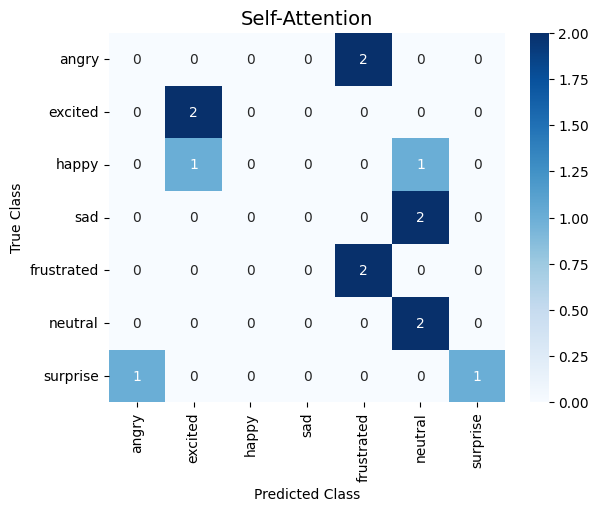

In [74]:
# cm_sa = cm_sa / np.sum(cm_sa, axis=0)
sns.heatmap(cm_sa, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Self-Attention', fontsize=14)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [75]:
wa_ca, uwa_ca, wf1_ca, uwf1_ca, cm_ca = evaluate_metrics(preds_ca, labels)
print('Cross-Attention: ')
print('Weighted Accuracy   {:.2f}%'.format(100*wa_ca))
print('Unweighted Accuracy {:.2f}%'.format(100*uwa_ca))
print('Weighted F1-score {:.4f}'.format(wf1_ca))
print('Unweighted F1-score {:.4f}'.format(uwf1_ca))

Cross-Attention: 
Weighted Accuracy   50.00%
Unweighted Accuracy 50.00%
Weighted F1-score 0.4102
Unweighted F1-score 0.4102


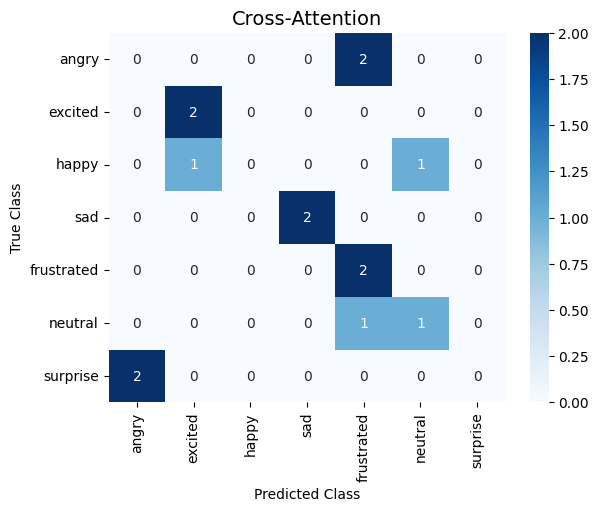

In [76]:
# cm_ca = cm_ca / np.sum(cm_ca, axis=0)
sns.heatmap(cm_ca, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Cross-Attention', fontsize=14)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()